In [17]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from missforest.missforest import MissForest
#pip install lightgbm
#pip install scikit-learn
#pip install MissForest

In [2]:
data = pd.read_csv("train_cleaned.csv")
data.head()

,Age,Ratings,RestaurantLat,RestaurantLon,DeliveryLocationLat,DeliveryLocationLon,TimeOrdered,TimeOrderPickedUp,WeatherConditions,RoadTrafficDensity,VehicleCondition,TypeOfOrder,TypeOfVehicle,MultipleDeliveries,Festival,City,TimeTaken,AgeGroup,Distance,Day
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,24,31-40,3.025149,Saturday
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,33,31-40,20.183530,Friday
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,26,19-30,1.552758,Saturday
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,21,31-40,7.790401,Tuesday
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,30,31-40,6.210138,Saturday


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40353 entries, 0 to 40352
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  40353 non-null  float64
 1   Ratings              40353 non-null  float64
 2   RestaurantLat        40353 non-null  float64
 3   RestaurantLon        40353 non-null  float64
 4   DeliveryLocationLat  40353 non-null  float64
 5   DeliveryLocationLon  40353 non-null  float64
 6   TimeOrdered          40353 non-null  object 
 7   TimeOrderPickedUp    40353 non-null  object 
 8   WeatherConditions    40353 non-null  object 
 9   RoadTrafficDensity   40353 non-null  object 
 10  VehicleCondition     40353 non-null  int64  
 11  TypeOfOrder          40353 non-null  object 
 12  TypeOfVehicle        40353 non-null  object 
 13  MultipleDeliveries   40353 non-null  int64  
 14  Festival             40353 non-null  object 
 15  City                 40353 non-null 

In [4]:
data['Distance'].describe()

count    40353.000000
mean        28.669572
std        315.930556
min          1.465067
25%          4.657673
50%          9.193521
75%         13.681492
max       6884.726399
Name: Distance, dtype: float64

### Further Cleaning of ResturantLat
From the visualisation, there is extereme outlier in distance. Upon futher discovery, there seems to be error in the data of ResturantLat. The value will be converted from negative to positive.

In [5]:
data.loc[data['Distance'] > 100, 'RestaurantLat'] *= -1

Recalculating distance

In [6]:
def calcDistance(row):
    lat1 = np.radians(row["RestaurantLat"])
    lon1 = np.radians(row["RestaurantLon"])
    lat2 = np.radians(row["DeliveryLocationLat"])
    lon2 = np.radians(row["DeliveryLocationLon"])
    return np.arccos(np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(lon2-lon1)) * 6371

In [7]:
data["Distance"] = data.apply(calcDistance, axis=1)

### -1 as NaN in MultipleDeliveries. Impute data using MissForrest based on other variables

In [8]:
data['MultipleDeliveries'].describe()

count    40353.000000
mean         0.707655
std          0.619418
min         -1.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: MultipleDeliveries, dtype: float64

### Since MissForrest dont accept time series, we create a new column to catergorise the time.

In [9]:
data['TimeOrdered'] = pd.to_datetime(data['TimeOrdered'], format='%H:%M:%S')

In [10]:
# Convert datetime to categories based on time of day
def categorize_time(datetime):
    hour = datetime.hour
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'

# Apply categorization function to your datetime column
data['OrderPeriod'] = data['TimeOrdered'].apply(categorize_time)

# Convert the newly created category column to categorical data type
data['OrderPeriod'] = pd.Categorical(data['OrderPeriod'], categories=['morning', 'afternoon', 'evening', 'night'], ordered=True)


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40353 entries, 0 to 40352
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Age                  40353 non-null  float64       
 1   Ratings              40353 non-null  float64       
 2   RestaurantLat        40353 non-null  float64       
 3   RestaurantLon        40353 non-null  float64       
 4   DeliveryLocationLat  40353 non-null  float64       
 5   DeliveryLocationLon  40353 non-null  float64       
 6   TimeOrdered          40353 non-null  datetime64[ns]
 7   TimeOrderPickedUp    40353 non-null  object        
 8   WeatherConditions    40353 non-null  object        
 9   RoadTrafficDensity   40353 non-null  object        
 10  VehicleCondition     40353 non-null  int64         
 11  TypeOfOrder          40353 non-null  object        
 12  TypeOfVehicle        40353 non-null  object        
 13  MultipleDeliveries   40353 non-

In [12]:
#Convert missing value back to NaN
data['MultipleDeliveries'].replace(-1 , np.nan, inplace=True)

columnstokeep = ['Age', 'Ratings', 'WeatherConditions', 'RoadTrafficDensity', 'VehicleCondition',
                 'TypeOfOrder', 'MultipleDeliveries', 'Festival', 'City', 'TimeTaken', 'Day', 'OrderPeriod']

Cleanedforimpute = data.loc[:, columnstokeep].copy()


In [14]:
# Get the list of nominal columns
nominal_columns = list(Cleanedforimpute.select_dtypes(include=["object", "category"]).columns)

# Get the indices of the nominal columns
cat = Cleanedforimpute[Cleanedforimpute.select_dtypes('object').columns]  
cat_ind = [Cleanedforimpute.columns.get_loc(c) for c in cat]

# Translate categorical fields to numeric
from sklearn import preprocessing
col_le = {}
Cleanedforimpute_trans = Cleanedforimpute.copy()
for col in nominal_columns:
    le = preprocessing.LabelEncoder()
    le.fit(Cleanedforimpute[col])
    Cleanedforimpute_trans[col] = le.transform(Cleanedforimpute[col])
    col_le[col] = le

# Add back in the NaNs
for col in nominal_columns:
    new_values = []
    for i in range(len(Cleanedforimpute)):
        if pd.isna(Cleanedforimpute.loc[i][col]):
            new_values.append(np.nan)
        else:
            new_values.append(Cleanedforimpute_trans.loc[i][col])
    Cleanedforimpute_trans[col] = new_values


In [18]:
# Initialize the magical forest
imputer = MissForest()

# Impute away
data_imputed = imputer.fit_transform(Cleanedforimpute_trans)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 128
[LightGBM] [Info] Number of data points in the train set: 39498, number of used features: 11
[LightGBM] [Info] Start training from score 0.744620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 128
[LightGBM] [Info] Number of data points in the train set: 39498, number of used features: 11
[LightGBM] [Info] Start training from score 0.744620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

In [19]:
data_imputed['MultipleDeliveries'].describe()

count    40353.000000
mean         0.742824
std          0.567133
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: MultipleDeliveries, dtype: float64

### Now we put the imputed data back into the original dataframe.

In [20]:
data['MultipleDeliveries'] = data_imputed['MultipleDeliveries']

In [39]:
data['MultipleDeliveries'] = data['MultipleDeliveries'].astype(int)

In [43]:
data['Age'] = data['Age'].astype(int)

## EDA on Numerical Values

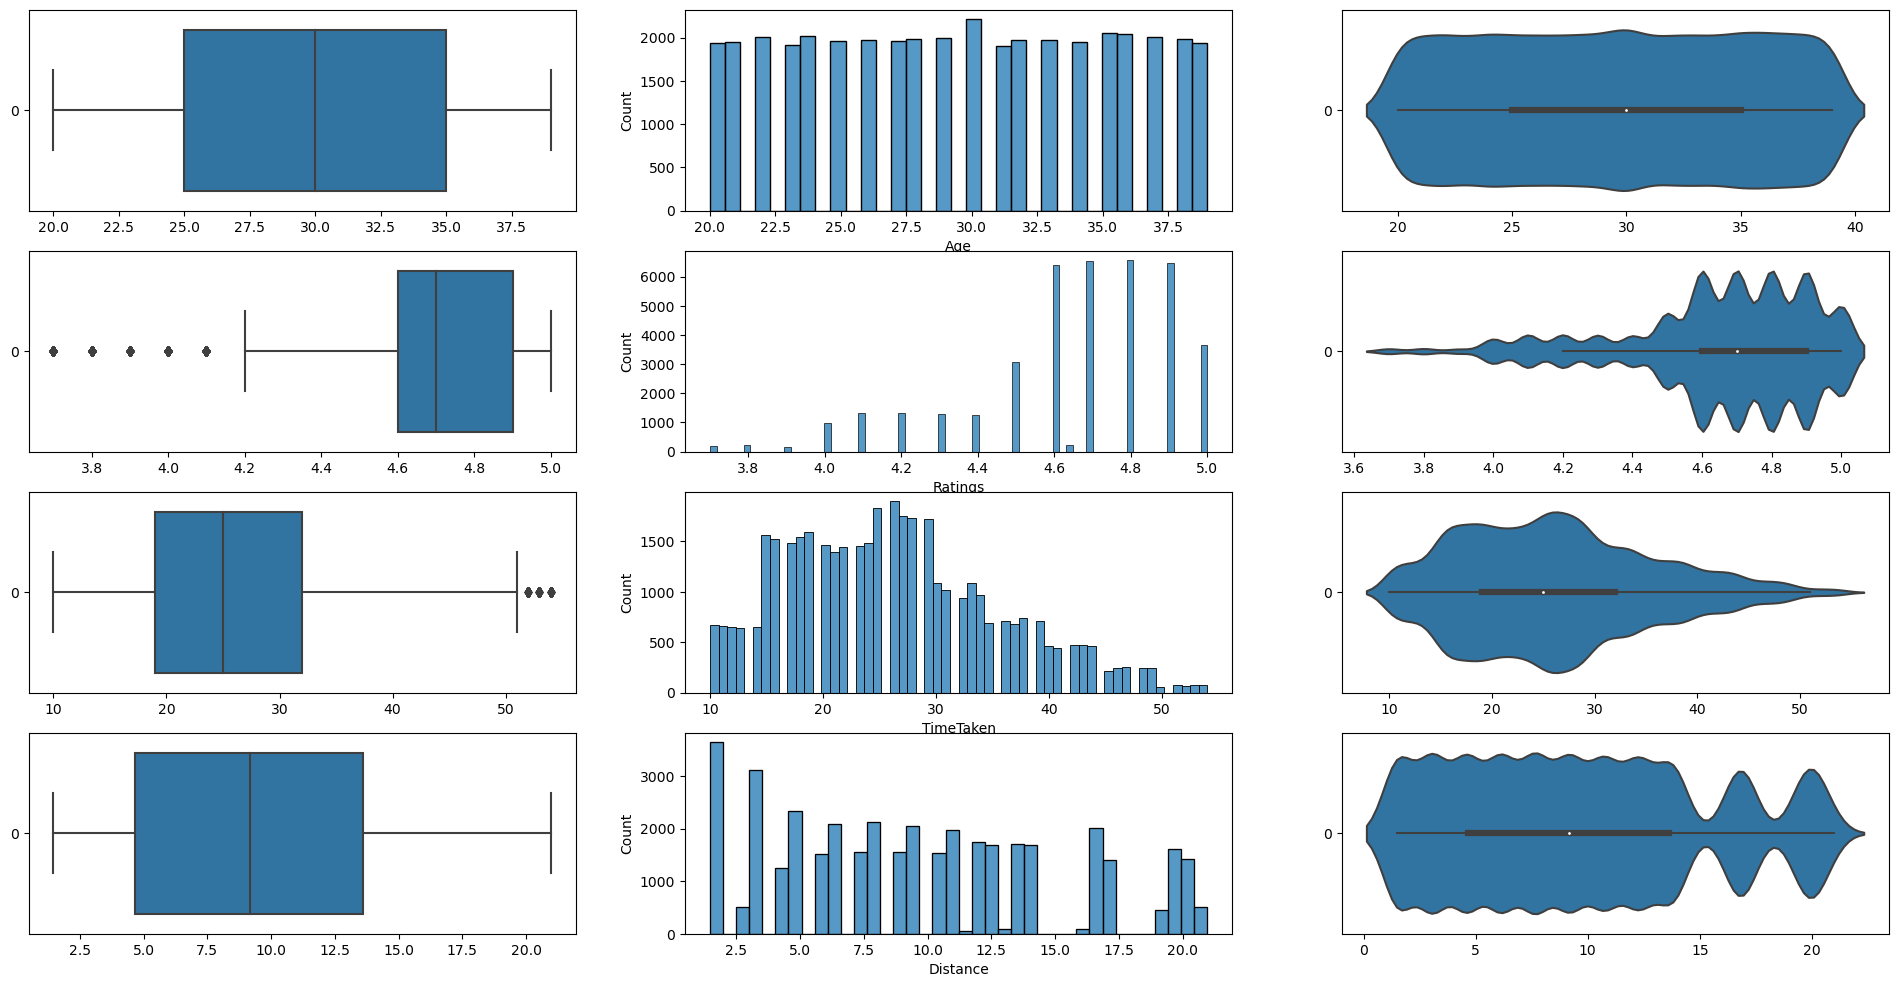

In [44]:
numeric = data[['Age', 'Ratings', 'TimeTaken', 'Distance']]
f, axes = plt.subplots(4, 3, figsize=(24, 12))

count = 0
for var in numeric:
    sb.boxplot(data = numeric[var], orient = "h", ax = axes[count,0])
    sb.histplot(data = numeric[var], ax = axes[count,1])
    sb.violinplot(data = numeric[var], orient = "h", ax = axes[count,2])
    count += 1

### Removing outliers using z-score based outlier removal

In [26]:
from scipy import stats

# Assuming 'columns_to_check' is a list of column names you want to check for outliers
columns_to_check = ['TimeTaken', 'Ratings']

# Compute z-scores for the specified columns
z_scores = stats.zscore(data[columns_to_check])

# Check for outliers based on z-score threshold of 3
outliers_mask = (np.abs(z_scores) < 3).all(axis=1)

# Update the original DataFrame by removing rows with outliers
data = data[outliers_mask]

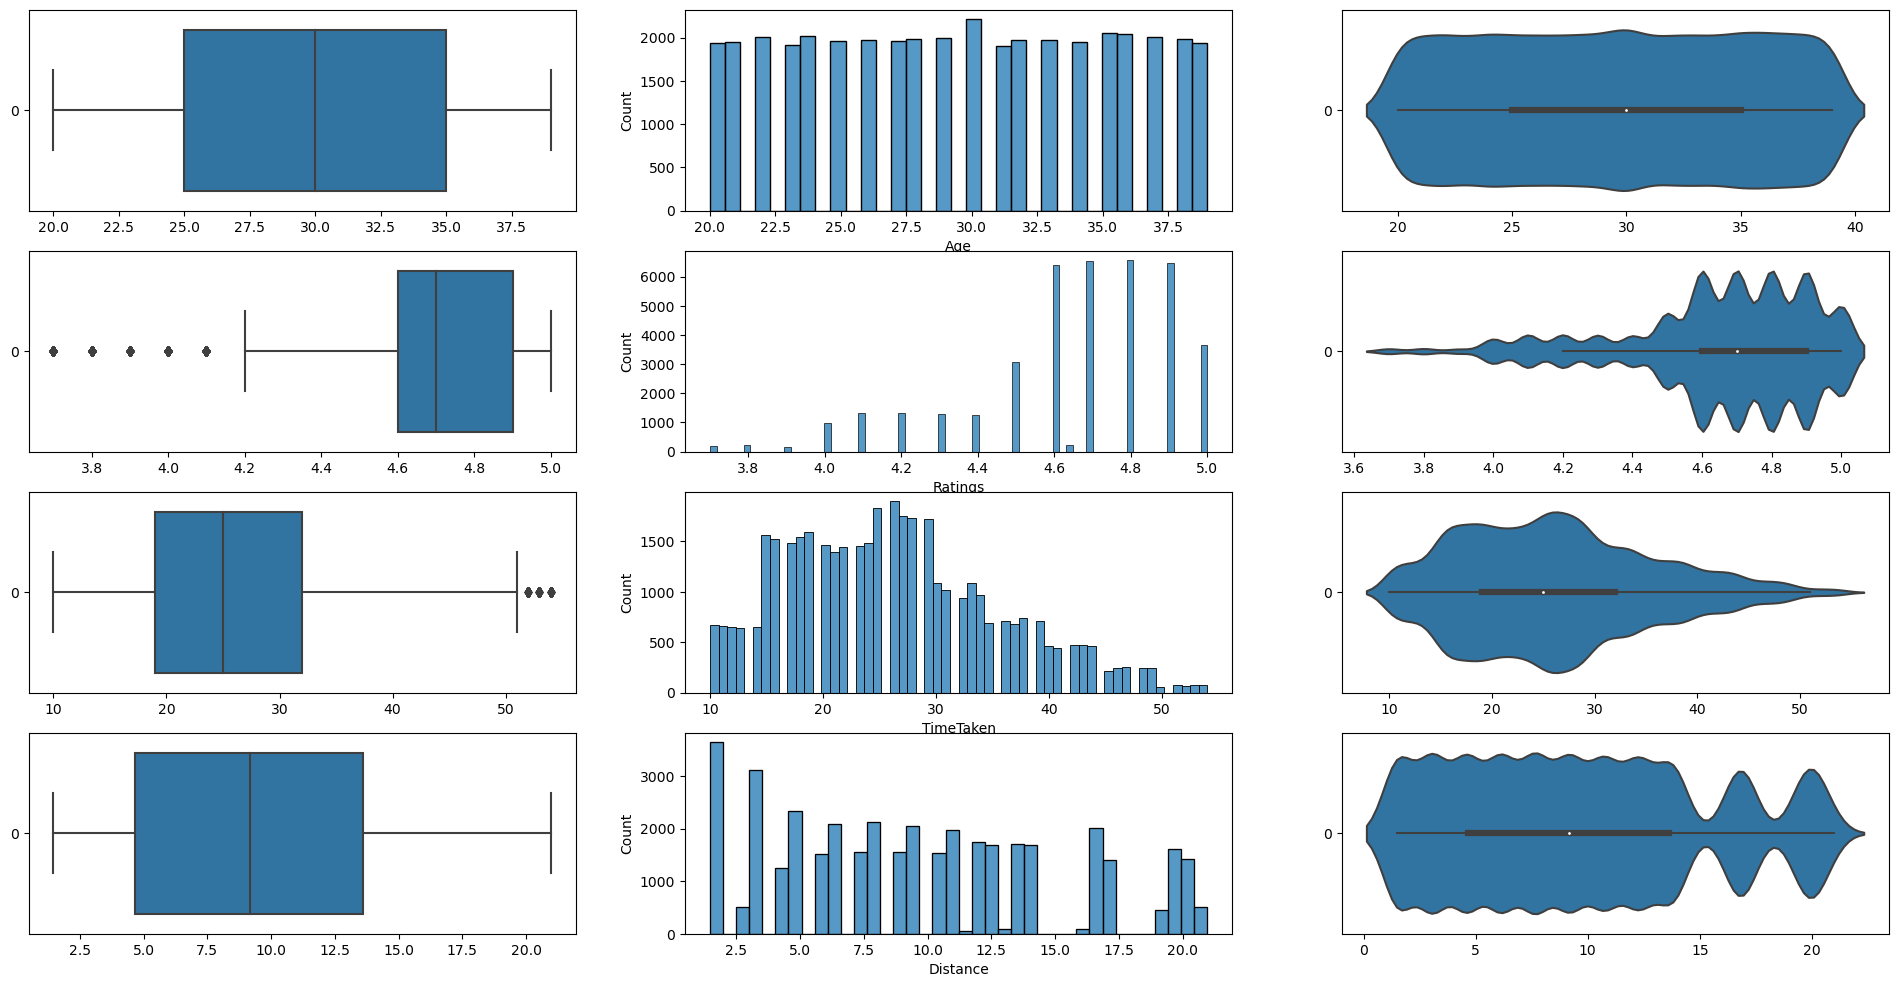

In [27]:
numeric = data[['Age', 'Ratings', 'TimeTaken', 'Distance']]
f, axes = plt.subplots(4, 3, figsize=(24, 12))

count = 0
for var in numeric:
    sb.boxplot(data = numeric[var], orient = "h", ax = axes[count,0])
    sb.histplot(data = numeric[var], ax = axes[count,1])
    sb.violinplot(data = numeric[var], orient = "h", ax = axes[count,2])
    count += 1

#### Using a heatamp, we will try to observe is there is any correlation between the numerical values

<Axes: >

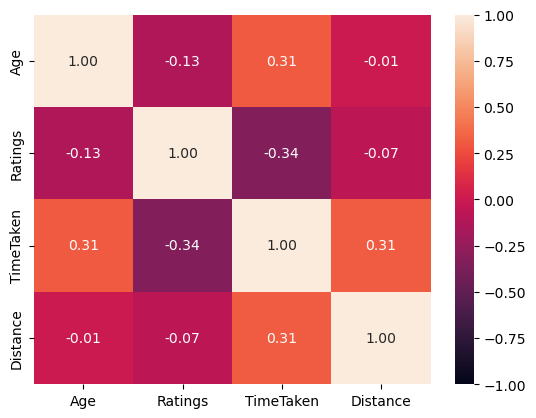

In [30]:
sb.heatmap(numeric.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

### Analysis of corelation matrix of numerical values
From the correlation matrix, we can observe that the overall correlation between variables are relatively low.

TimeTaken and Age is slightly corelated.

Similarly, TimeTaken and distance is also slightly correlated.

While Ratings has slight negative correalton with TimeTaken.

So we will look into Timetaken, Distance and Ratings

### EDA on catergorical Variables
#### Now we try to explore the categorical values with each numerical value to see if we can derive futher insights.

### Age

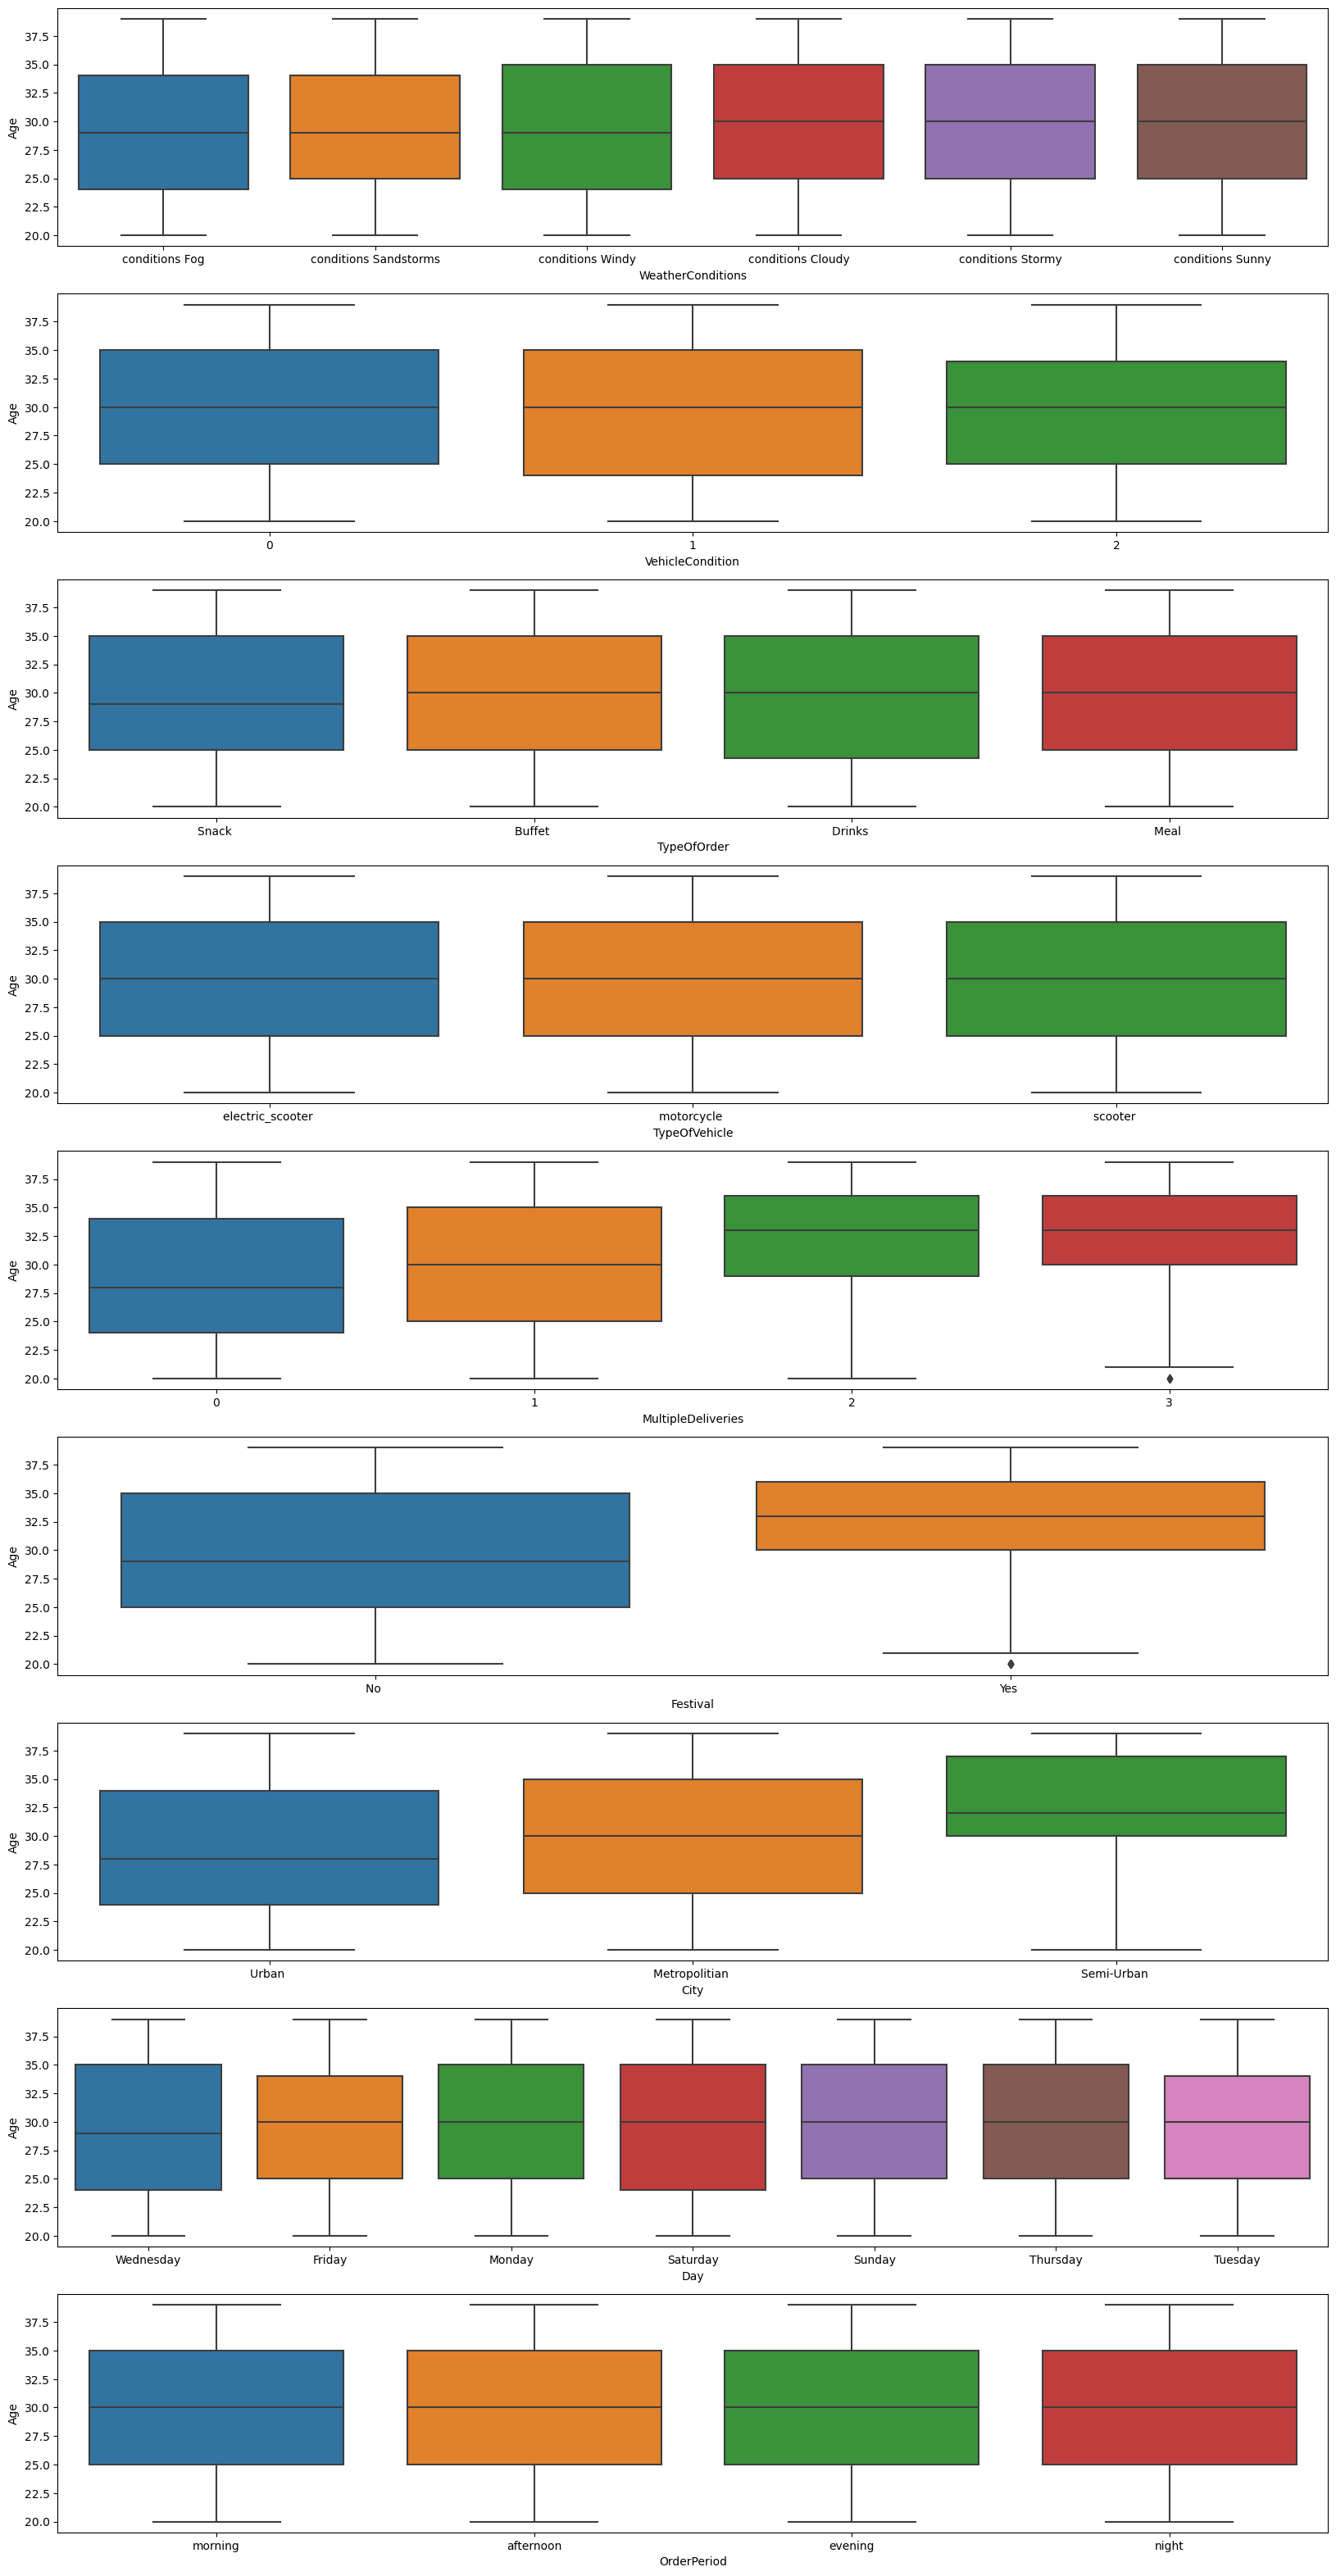

In [67]:
cat = data[['WeatherConditions', 'VehicleCondition', 'TypeOfOrder', 'TypeOfVehicle', 'MultipleDeliveries', 'Festival', 'City', 'Day', 'OrderPeriod']]


count = 0
f, axes = plt.subplots(9, 1, figsize=(20,40))
for i,x in enumerate(cat):
    order = data.groupby(by=[x])['Age'].median().sort_values().index
    sb.boxplot(data=data, x=x, y='Age', ax = axes[count], order=order)
    count+=1

plt.show()

### Insights from comparing age to catergorical features
Here we observe that the range is same for all. Previously we saw that those NaN values we drop contain alot of Delivery Riders aged 60 and above. We believe that those data are corrupted due large amount of data missing in the same column. Hence, it becomes hard to derive anything for age. However, we can still make slight observations.

1: The median of Age increases with the amount of MultipleDeliveries.

2: The median of Age is high on festival as compared to non festival day. 

3: We can see distinct median for City as well. With Urban having the lowest media age and Semi-Urban having the highest.


### Ratings

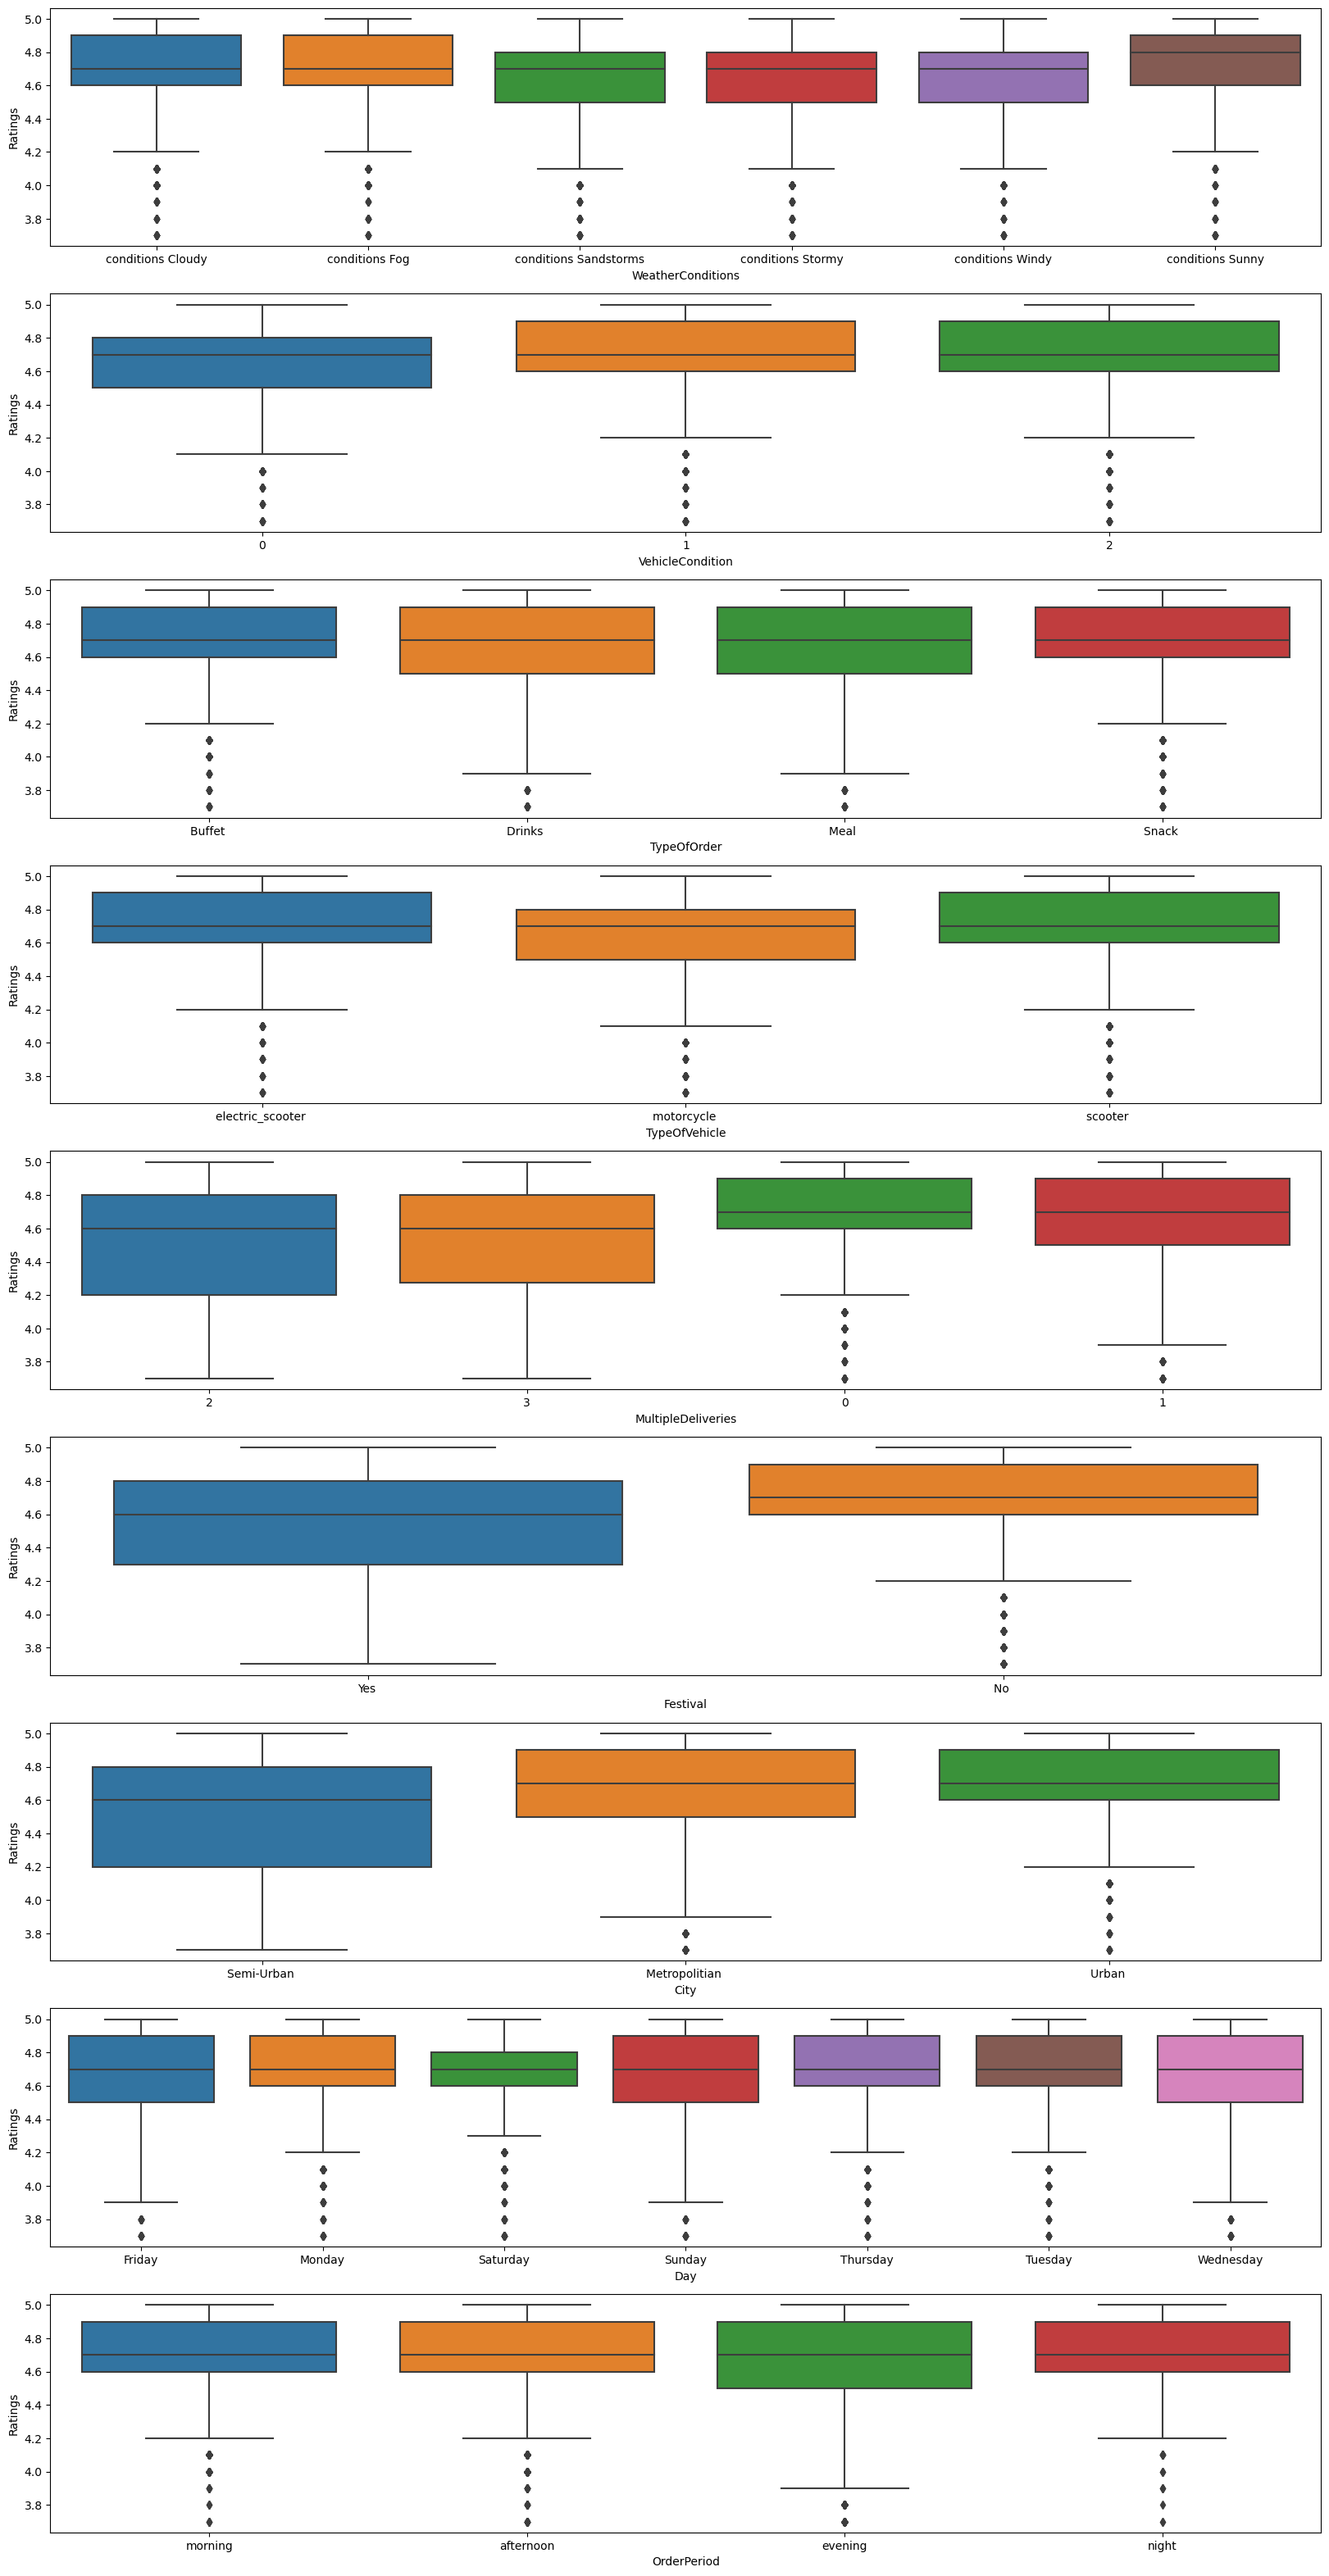

In [68]:
cat = data[['WeatherConditions', 'VehicleCondition', 'TypeOfOrder', 'TypeOfVehicle', 'MultipleDeliveries', 'Festival', 'City', 'Day', 'OrderPeriod']]


count = 0
f, axes = plt.subplots(9, 1, figsize=(20,40))
for i,x in enumerate(cat):
    order = data.groupby(by=[x])['Ratings'].median().sort_values().index
    sb.boxplot(data=data, x=x, y='Ratings', ax = axes[count], order=order)
    count+=1

plt.show()

### Insights from comparing Ratings to catergorical features
When comparing Ratings to Categorial features, there is more distinction between each category.

#### WeatherConditions:
The median accross all appears relatively similar, however the IQR seems slightly different. IQR are generally lower in Sandstorms, Stormy and Windy as compared to Cloudy, Fog and Sunny.

#### VehicleConditions: 
Similarly, median across all appear relatively similar. IQR Increases as VehicleCondition get better. Since Ratings and Delivery time are slightly negatively correlated. We hypothesys that perhaps a better conditioned vehicle is able to send a delivery in a shorter time. Resulting in a higher rating.

#### TypeOfOrder: 
Not much insights.

#### TypeOfVehicle:
Not much insights.

#### MultipleDeliveries: (maybe remove outliers)
Lesser MultipleDeliveries generally have a higher rating as compared to more MultipleDeliveries. Similarly, we hypothesys that having more simulatenous deliveries tend to mean futher distances and/or longer delivery time. Therefore, a lower rating.

#### Festival: (maybe remove outliers)
Ratings during non festival days seems to be on average higher than festival days. Again, perhaps during festival days, the deliver takes longer and/or distances are further.

#### City: (maybe remove outliers)
Ratings in Urban areas on average have a high Rating as comapred to semi-Urban and Metropolitian. Perhaps due to simialr reasons listed earlier.




### Timetaken

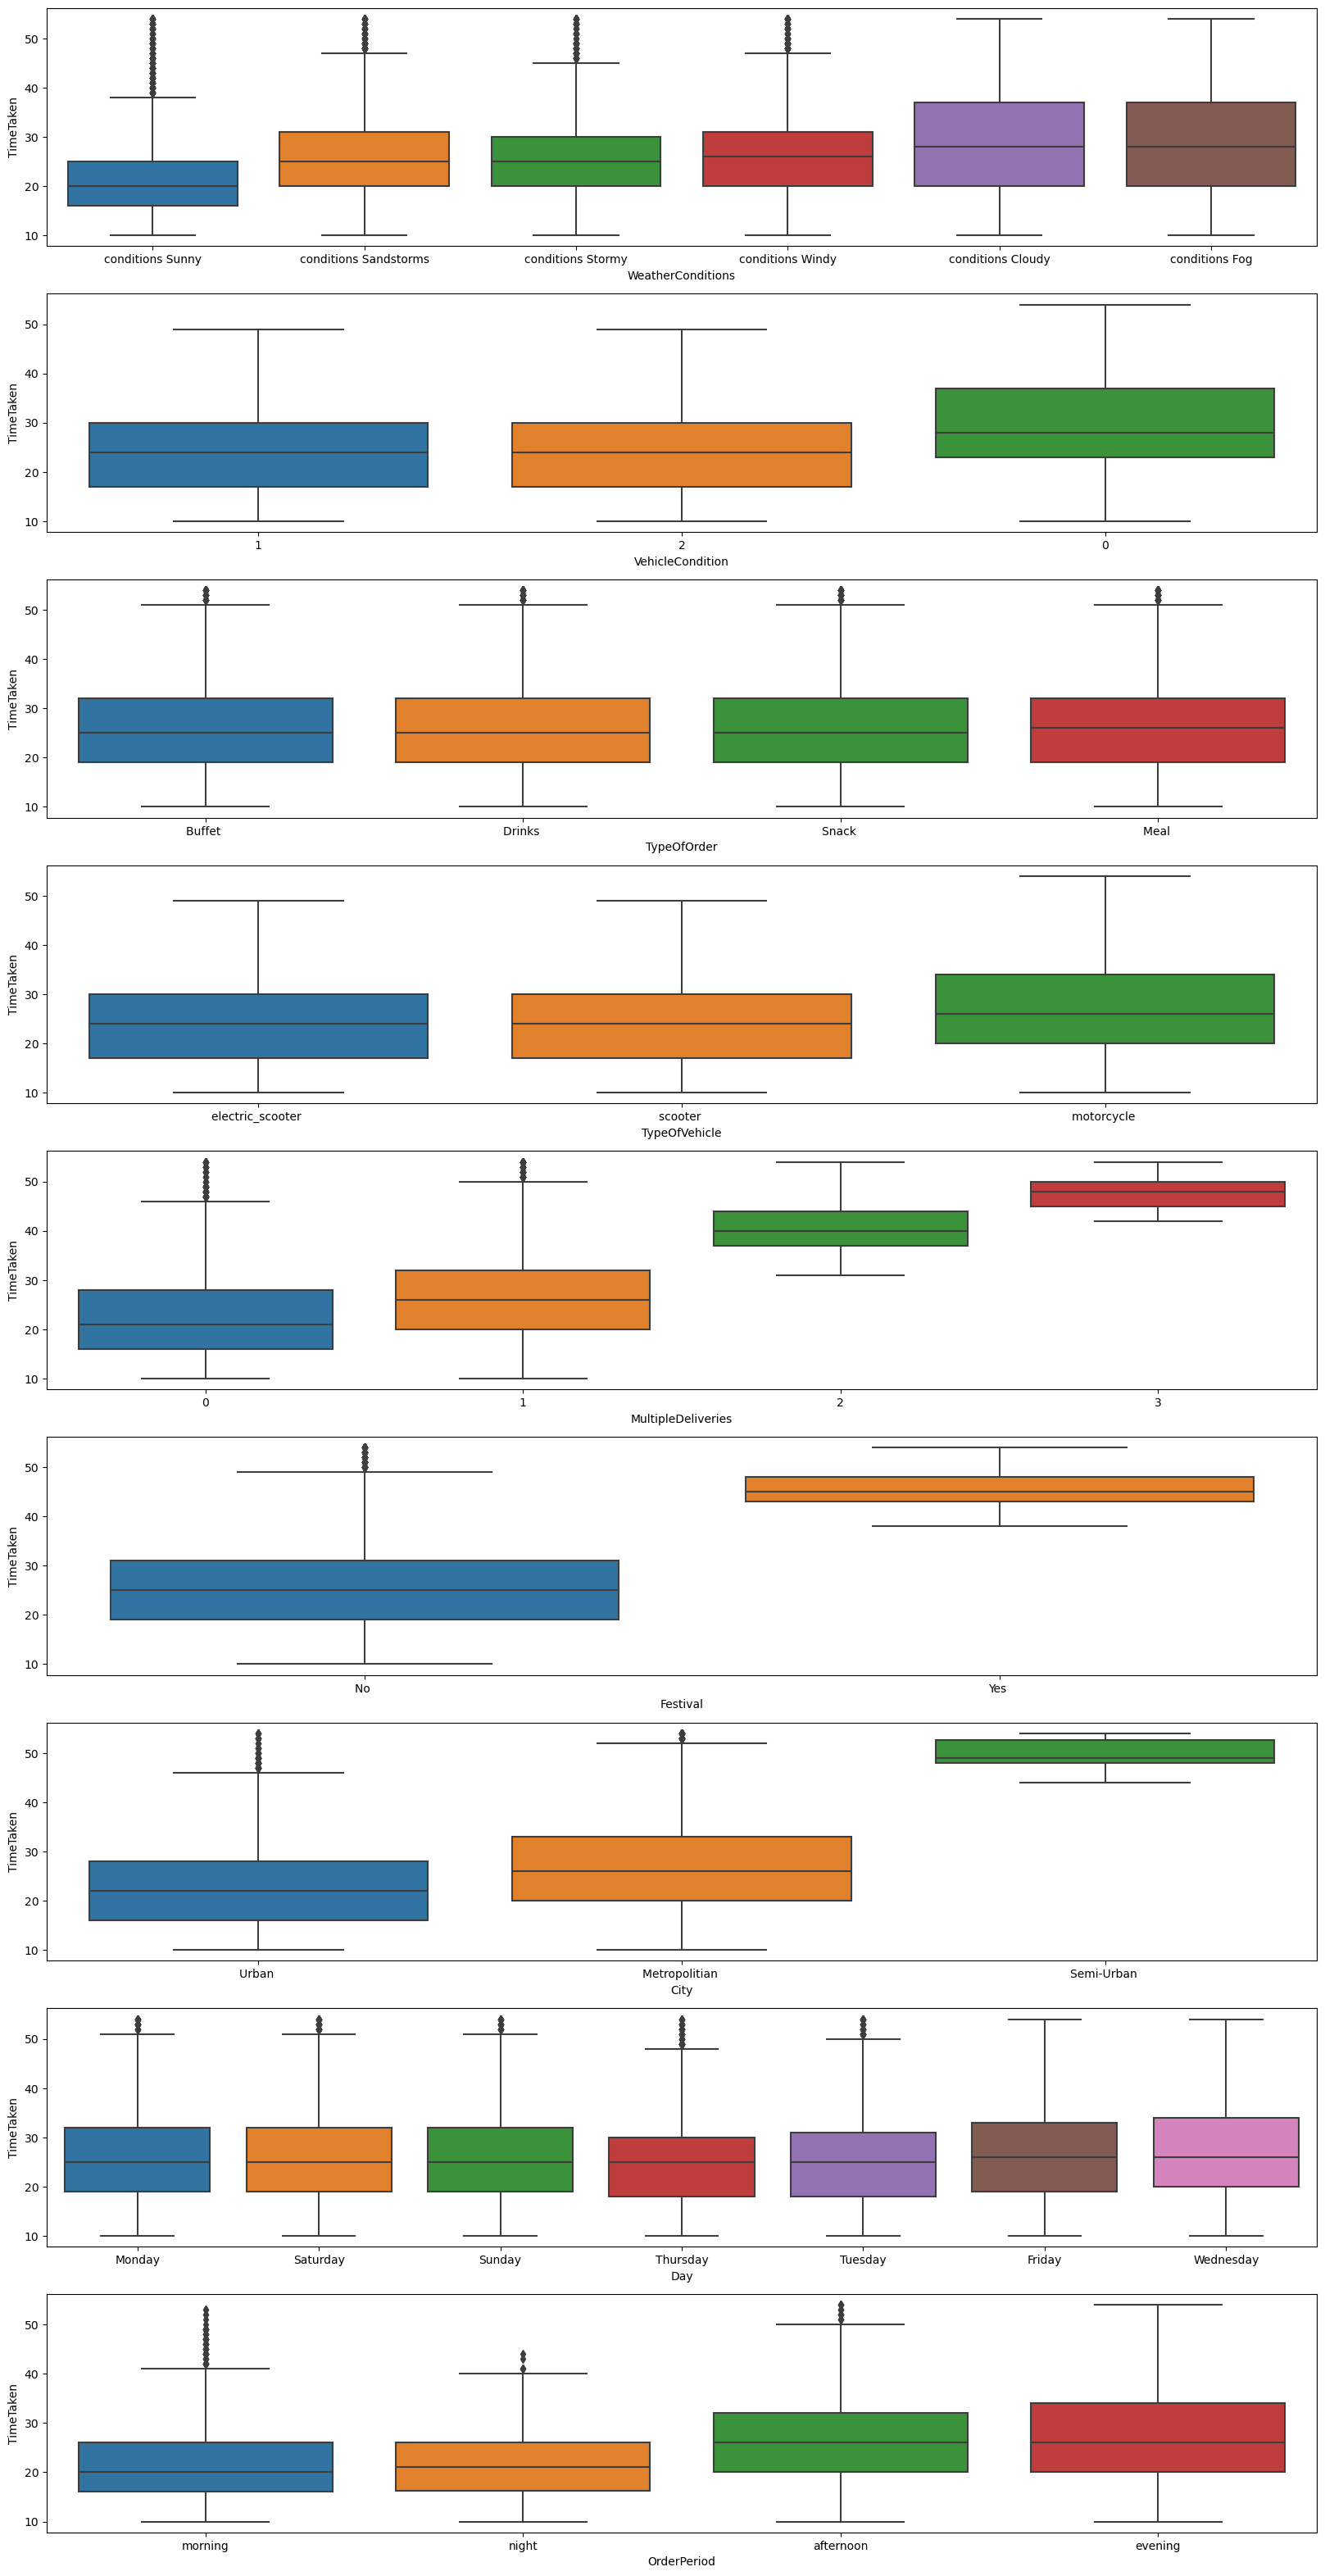

In [64]:
cat = data[['WeatherConditions', 'VehicleCondition', 'TypeOfOrder', 'TypeOfVehicle', 'MultipleDeliveries', 'Festival', 'City', 'Day', 'OrderPeriod']]


count = 0
f, axes = plt.subplots(9, 1, figsize=(20,40))
for i,x in enumerate(cat):
    order = data.groupby(by=[x])['TimeTaken'].median().sort_values().index
    sb.boxplot(data=data, x=x, y='TimeTaken', ax = axes[count], order=order)
    count+=1

plt.show()

### Insights from comparing TimeTaken to Catergorical Values

#### WeatherConditions: (maybe remove outliers)
During Sunny conditions, we can observe the most amout of outliers. We also observe multiple outliers from other conditions

#### VehicleCondition:
Unable to derive any insights

#### TypeOfOrder:
Unable to derive any insghts

#### TypeOfVehicle:
Surpisingly motorcycle have the highest median. Perhaps motorcycle have deliveries that are futher, which concur with the correlation between timetaken and distance earlier. 

#### MultipleDeliveries: (maybe remove outliers)
We can distinctly see that the increase in MultipleDeliveries does result in long time taken on average. This confirms our previous hypothesis when comparing Ratings to Catergorical values.

#### Festival: (maybe remove outliers)
Again, we can distintly see that on festival dayas the time taken is higher than on non festival days. Which also confirms our previous hypothesis of lower ratings. 

#### City: (maybe remove outliers)
Again our hypothesis when comapring Ratings and categorical values are confirmed.

#### OrderPeriod: (maybe remove outliers)
Afternoon and Evening have a higher median.




### Distance

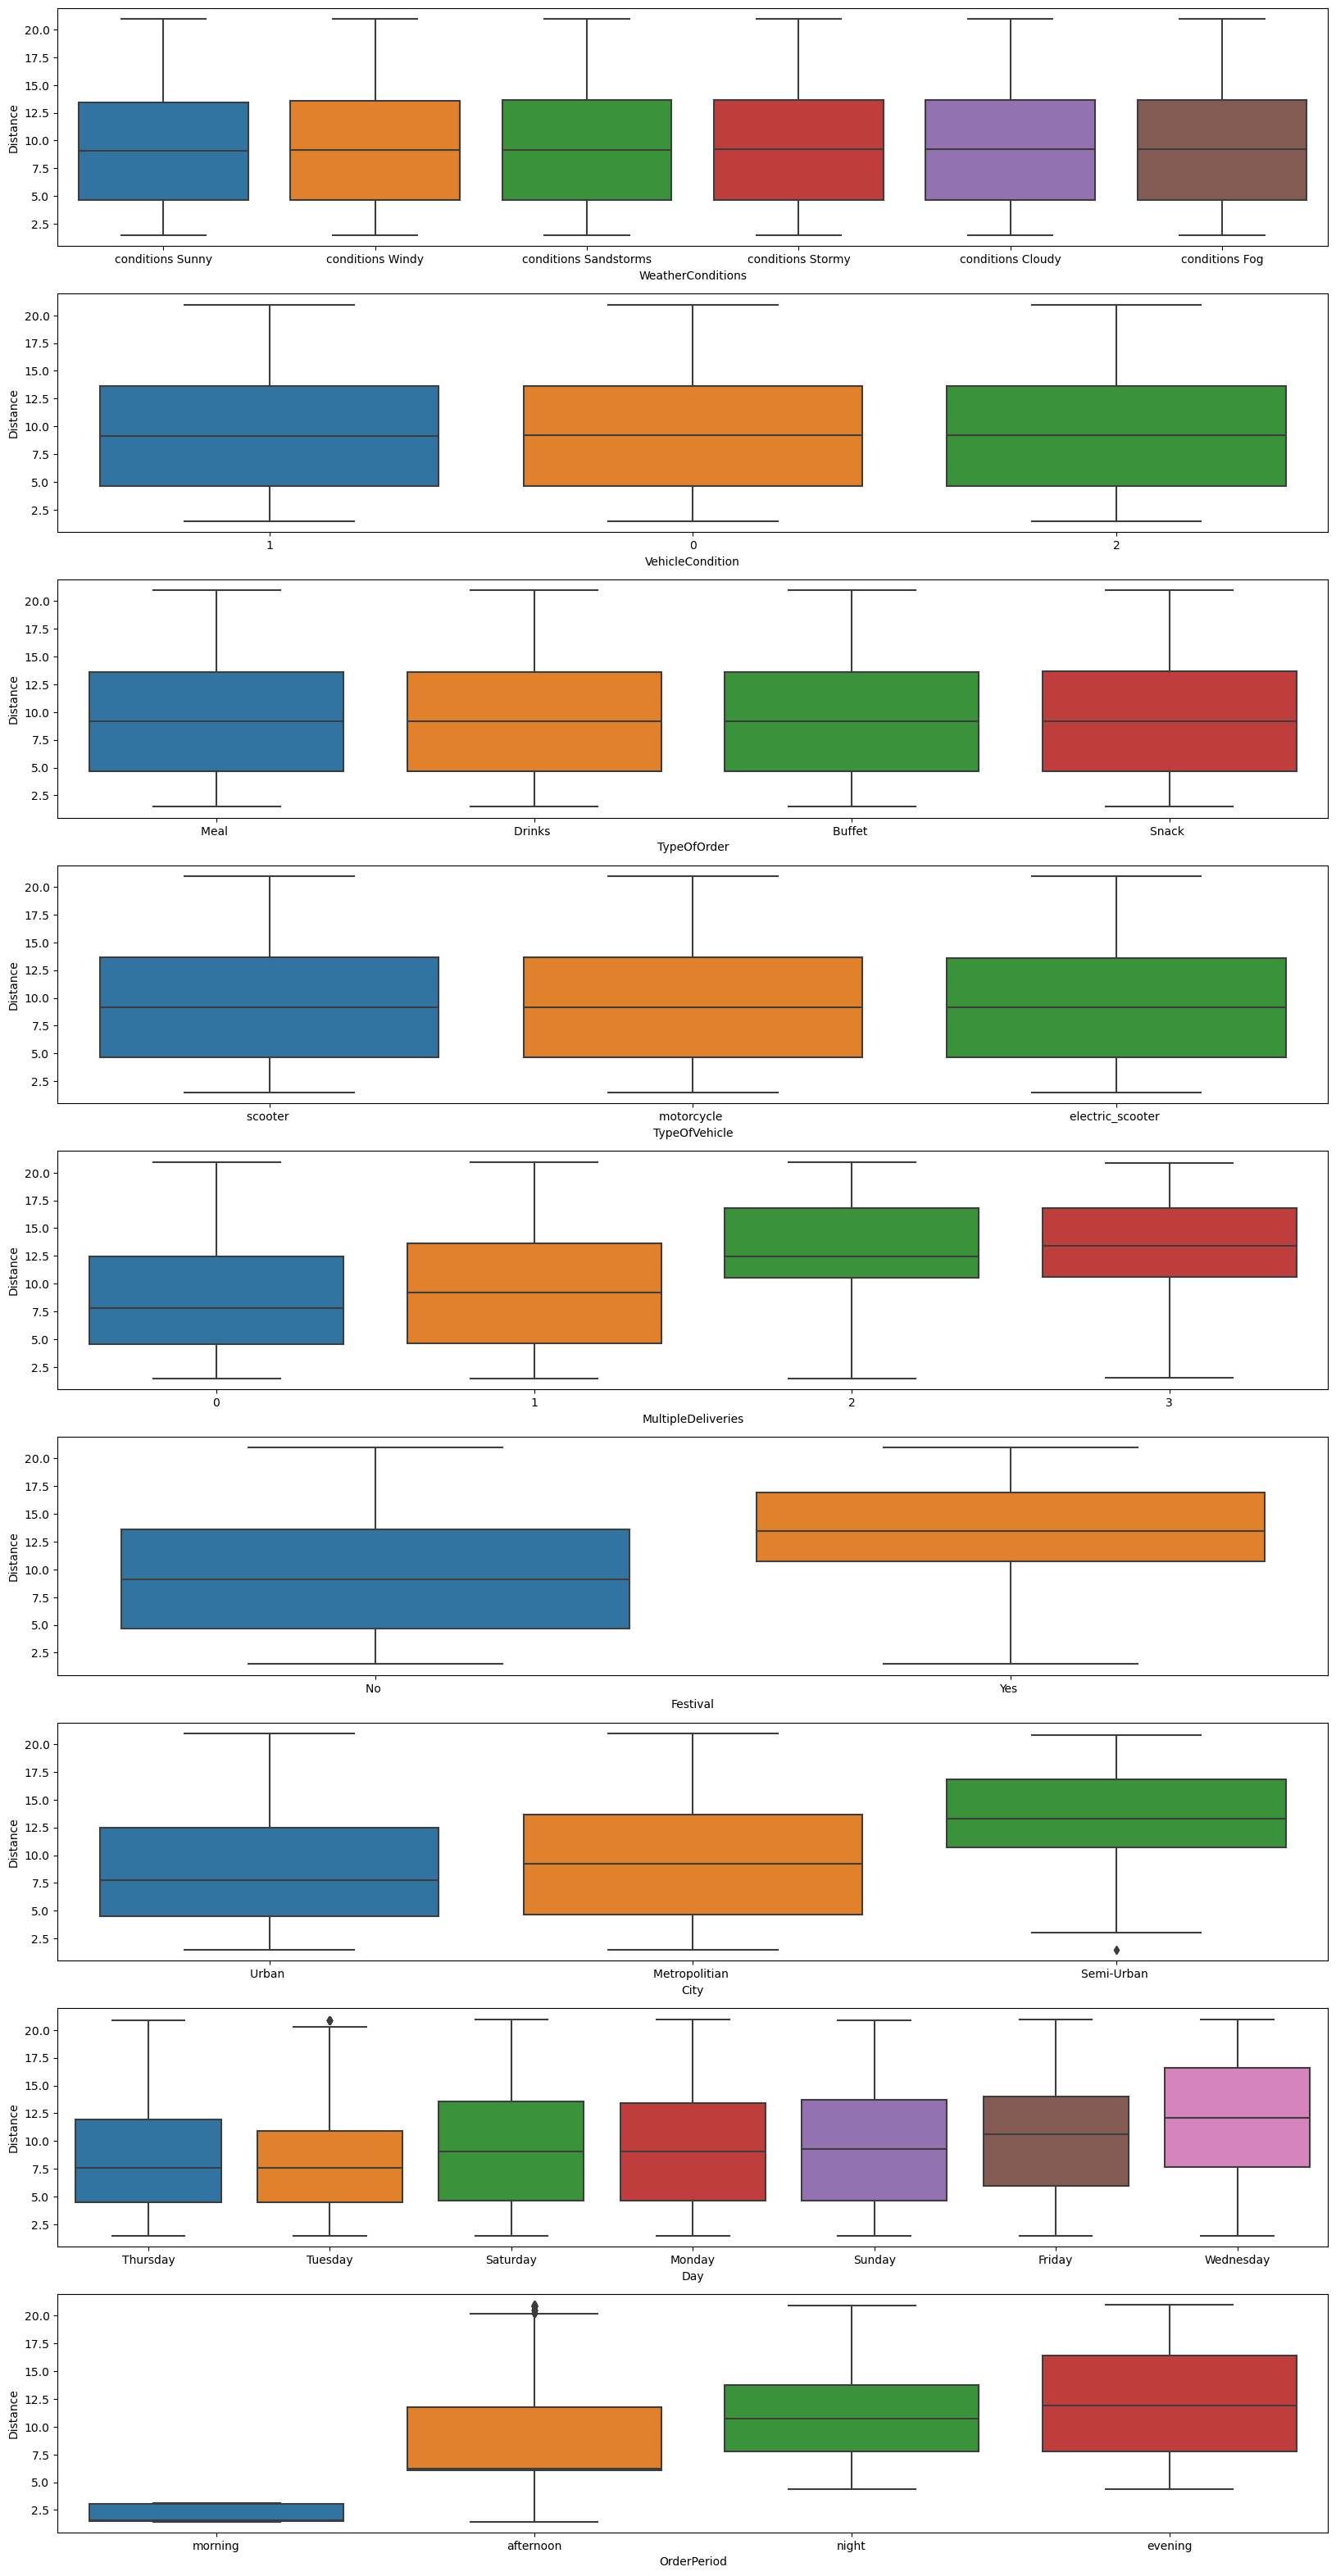

In [69]:
cat = data[['WeatherConditions', 'VehicleCondition', 'TypeOfOrder', 'TypeOfVehicle', 'MultipleDeliveries', 'Festival', 'City', 'Day', 'OrderPeriod']]


count = 0
f, axes = plt.subplots(9, 1, figsize=(20,40))
for i,x in enumerate(cat):
    order = data.groupby(by=[x])['Distance'].median().sort_values().index
    sb.boxplot(data=data, x=x, y='Distance', ax = axes[count], order=order)
    count+=1

plt.show()

### Insights from comparing Distance to Catergorical Values

#### WeatherConditions, VehicleCondition, TypeOfOrder:
No insights.

#### TypeOfVehicle:
Previously, we hypothesys that motorcycle could have delivered futher distances. As we can see this is not the case, perhaps it is having multiple deliveries slowing down the delivery time.

#### MultipleDeliveries:
We observed that as the simulatneous delivery increases the distance increases and this is also the case TimeTaken. This 2 observation confirms our hypothesis on having more multipledeliveries resulting in a lower rating.

#### Festival:
We observed that the range for both Yes and No for festival are similar. However, the median distance is higher on festival days, which also concurs with the 2 previous observation when comparing to Ratings and Timetaken.

#### City:
The observation further confirm our hypothesis.

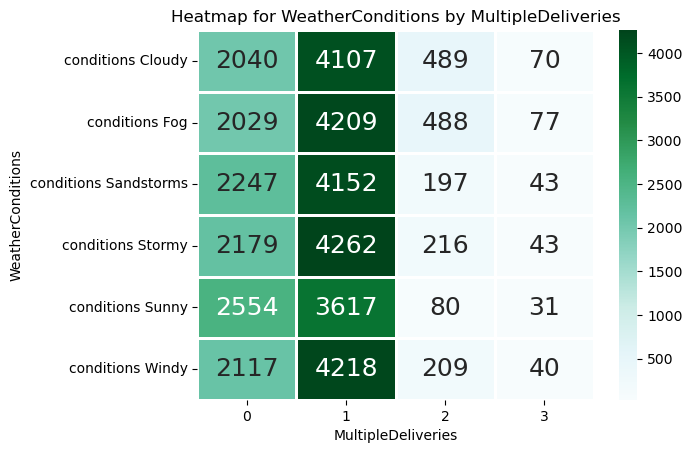

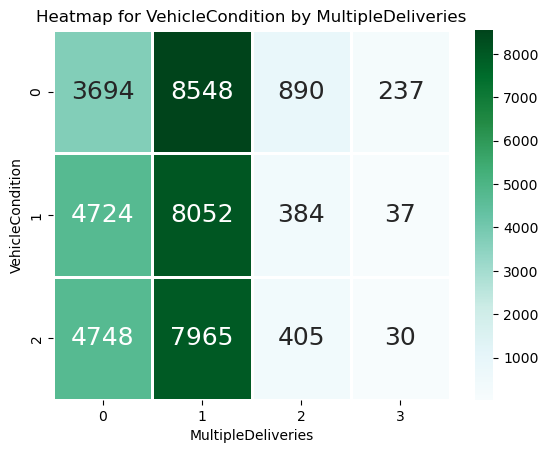

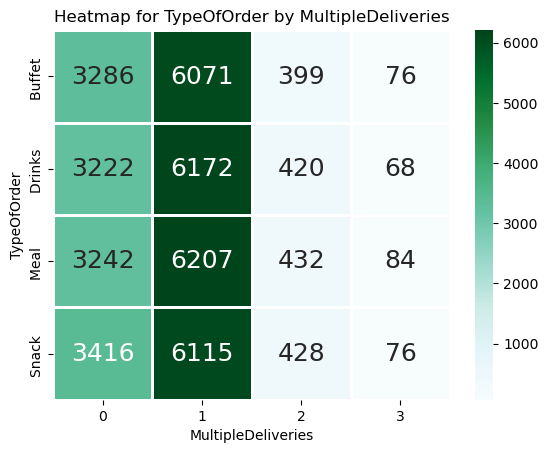

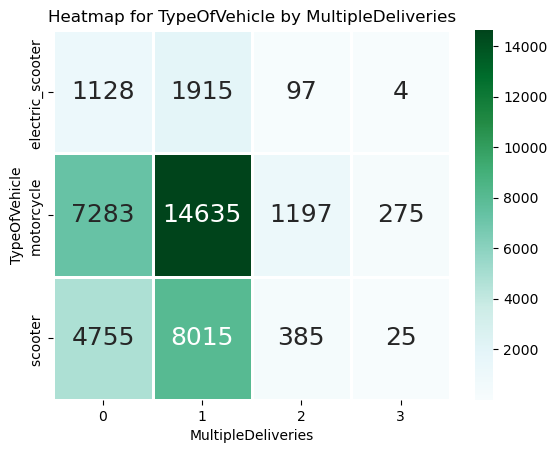

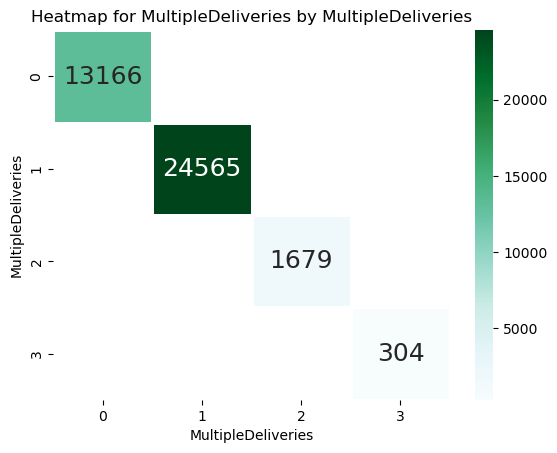

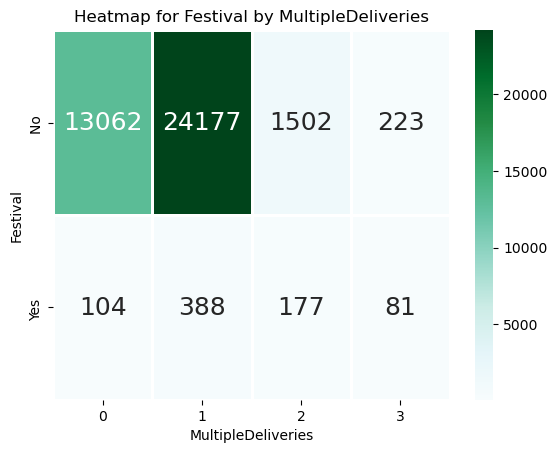

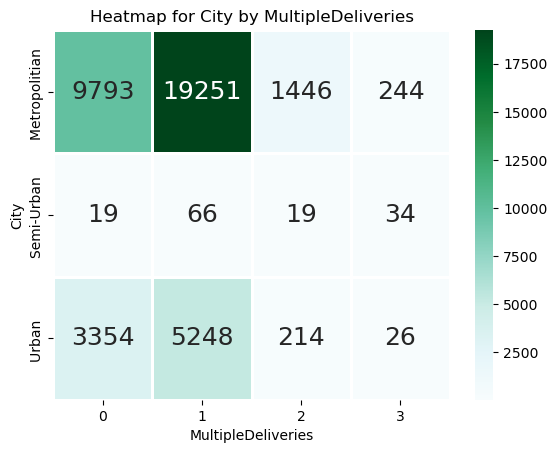

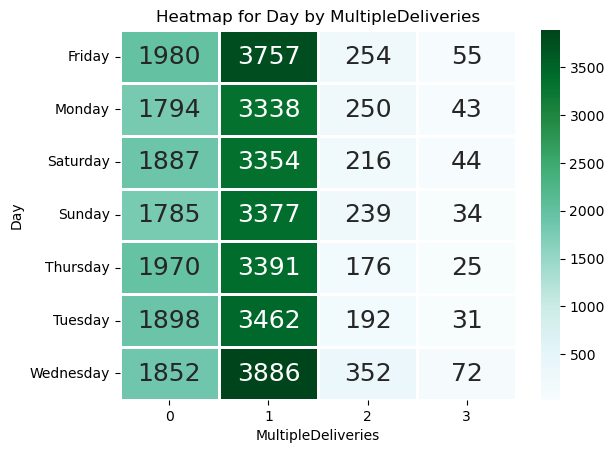

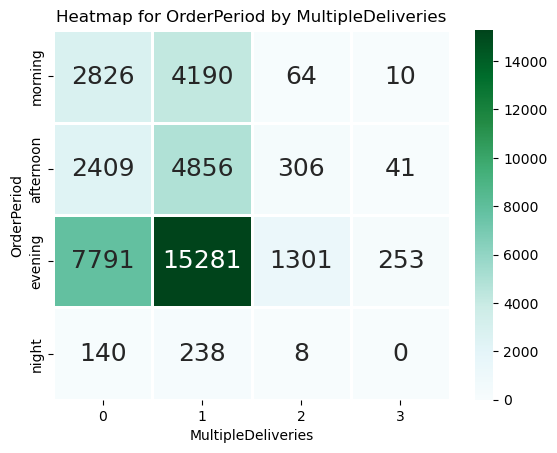

In [75]:
Cat = ['WeatherConditions', 'VehicleCondition', 'TypeOfOrder', 'TypeOfVehicle', 'MultipleDeliveries', 'Festival', 'City', 'Day', 'OrderPeriod']

# Iterate over selected columns
for col in Cat:
    # Create a heatmap for the combination of 'WeatherConditions' and the current column
    sb.heatmap(data.groupby([col,'MultipleDeliveries']).size().unstack(), 
               linewidths=1, annot=True, fmt='g', annot_kws={"size": 18}, cmap="BuGn")
    # Set the title for the heatmap
    plt.title(f"Heatmap for {col} by MultipleDeliveries")
    # Show the heatmap
    plt.show()